In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
def rk4(f,y0,dt,n,gamma):
  t = np.linspace(0, n * dt, n + 1)
  y = np.zeros((n+1, len(y0)))
  y[0] = y0
  for i in range(n):
    k1 = dt * f(t[i], y[i],gamma)
    k2 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k1,gamma)
    k3 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k2,gamma)
    k4 = dt * f(t[i] + dt, y[i] + k3,gamma)
    y[i + 1] = y[i] + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)
  return y,t

In [ ]:
#Dispersion relation
R_dim = 30e3
R_nondim = R_dim/300e3
beta_dim = 2e-12
beta_nondim = beta_dim * 86400 * 300e3

#Fourier harmonics
S = 10 #spectral radius
N = 41

def omega(k,l):
    return -beta_nondim * k / (k**2 + l**2 + R_nondim**-2)

P = 5 #radius of peak
H = 0.005 #height of peak (max amplitude)

def A(k,l):
  return H * np.exp(-0.5*(k**2+l**2-P**2)**2/(2*P**2))

In [ ]:
k,l = np.linspace(-S,S,N),np.linspace(-S,S,N)
K,L = np.meshgrid(k,l)
np.random.seed(0)
phi = np.random.uniform(0,2*np.pi,size=(N,N))
omega_vals = omega(K,L)
A_vals = A(K,L)

def modulo_grid(x, y):
  x_mod = np.mod(x + np.pi, 2 * np.pi) - np.pi
  y_mod = np.mod(y + np.pi, 2 * np.pi) - np.pi
  return x_mod, y_mod

def streamfunction(t,pos):
  x_mod,y_mod = modulo_grid(*pos)
  psi = np.real(np.sum(A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  return psi

def f(t,pos,gamma):
  x_mod,y_mod = modulo_grid(*pos)
  dpsi_dx = np.real(np.sum(1j*K*A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  dpsi_dy = np.real(np.sum(1j*L*A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))

  dphi_dx = dpsi_dx
  dphi_dy = dpsi_dy

  u = gamma * dphi_dx - (1-gamma) * dpsi_dy
  v = gamma * dphi_dy + (1-gamma) * dpsi_dx

  return np.array([u,v])

In [1]:
#Randomly select initial points
num_points = 10

x_coords = np.random.uniform(-np.pi, np.pi, num_points)
y_coords = np.random.uniform(-np.pi, np.pi, num_points)
initial_conditions = np.column_stack((x_coords, y_coords))

n = 2000 #number of time steps
dt = 0.1 #value of the timestep
time_span = n * dt

solutions = []
gamma = 0.05
for y0 in initial_conditions:
  sol,t = rk4(f,y0,dt,n,gamma)
  solutions.append(sol)


NameError: ignored

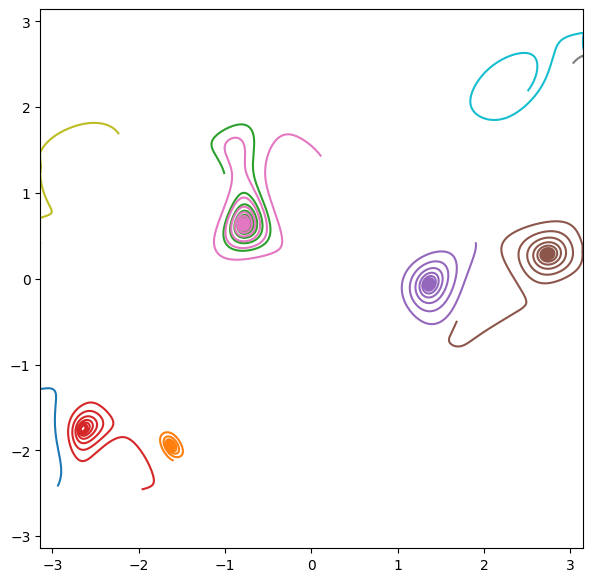

In [ ]:
#Visualise the trajectories
plt.figure(figsize=(7, 7))
for sol in solutions:
  plt.plot(sol[:,0],sol[:,1])

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()